In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14


In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from torchvision.transforms import v2


In [109]:
from pymono.cnns import cnn_evaluation, x_single_run, x_train_cnn
from pymono.cnns import Conv2dPars,  MaxPool2dPars,  LinealLayerPars
from pymono.cnns import build_conv_layer, build_conv_layers, build_linear_layers
from pymono.cnns import CNN, ResNet10, ResNet8, ResBlock

In [39]:
from pymono.plt_funcs import  plot_loss, plot_accuracy, cifar_plot_image_and_label 
from pymono.plt_funcs import  plot_energies2
from pymono.cnn_plots import plot_images2, plot_images_and_labels

In [25]:
from pymono.cnn_aux import get_file_names_format1, get_image_file_data, get_img_file_metadata, get_energy2

In [63]:
from pymono.xdataset import XDataset 
from pymono.mono_dl import mono_data_loader

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [7]:
def print_features(train_loader):
    train_features, train_labels = next(iter(train_loader))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")

## Read and anlalyze data
- df1c is the directory containing images and labels for events classified as single cluster (1c)
- df2c is the directory containing images and labels for events classified as double cluster (2c)
- dfnc is the directory containing images and labels for events classified as multiple cluster (nc)
- Files are in format1:
    - images files are of the form: images_n.npy, where n is a number.
    - labels are stored in a single file (labels.csv)

In [8]:
data_dir = Path(os.environ['MONOLITH_DATA'])
dir_root = os.path.join(data_dir,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_NX")
d1c = os.path.join(dir_root,"df1c")
d2c = os.path.join(dir_root,"df2c")
dnc = os.path.join(dir_root,"dfnc")

In [13]:
img_names, csv_name = get_file_names_format1(d1c)

In [15]:
img_names[0]

'/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_NX/df1c/images_1.npy'

In [12]:
csv_name

['/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_NX/df1c/labels.csv']

### Label data
- When sorted by value, label data corresponds to the image stored in the directory.
- event_id = 10000 x image_number, so that event 1004 corresponds to the fourth image in file images_1.npy

In [14]:
df1c = pd.read_csv(csv_name[0]).sort_values(by="event_id")
df1c.head(10)

,event_id,e,x,y,z,t
63683,10004,0.510118,18.645067,12.477487,29.249544,0.116340
63684,10006,0.509274,13.566376,1.647984,21.156849,0.090734
63685,10014,0.509922,-5.014233,5.060986,12.715019,0.062352
63686,10018,0.508170,-22.957691,-9.322307,45.483715,0.171746
63687,10024,0.508948,-3.514938,-0.639491,15.746504,0.074194
63688,10026,0.508879,18.973616,-6.031100,16.421364,0.074508
63689,10027,0.508849,11.437413,-22.155209,40.912632,0.157729
63690,10028,0.509717,9.708068,3.101630,13.316263,0.064982
63691,10029,0.509517,0.335767,-11.193620,21.898740,0.093051
63692,10030,0.509092,16.716444,15.401320,25.922293,0.107143


#### Example
- Images and labels in first file of directory

In [17]:
imgs, imgf_path, imgf_name, imfn = get_image_file_data(img_names,img_file_index=0)
print(f"image file path = {imgf_path}")
print(f"image file name = {imgf_name}")
print(f"image file number = {imfn}")
print(f"number of images in file = {len(imgs)}")

image file path = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_NX/df1c/images_1.npy
image file name = images_1.npy
image file number = 1
number of images in file = 2481


In [21]:
df1cs = get_img_file_metadata(df1c, imfn)  # This are the events corresponding to the images
print(f"number of labels in file = {len(df1cs)}")

number of labels in file = 2481


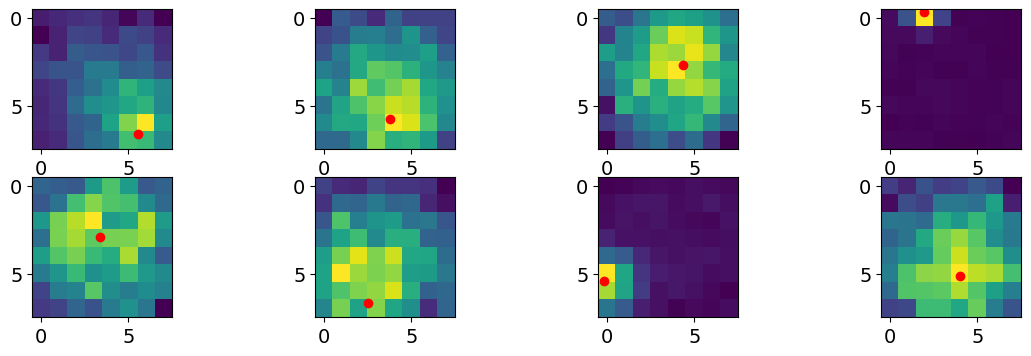

In [23]:
plot_images2(imgs, df1cs, (0,8), pixel_size = 6, grid_size=8)

In [27]:
energy = get_energy2(imgs)

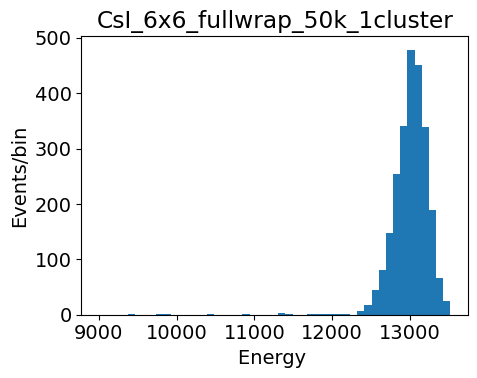

In [30]:
plot_energies2({"CsI_6x6_fullwrap_50k_1cluster":energy}, xmin=9000, xmax=max(energy),num_bins = 50)

## Load data
- No normalization. 

In [33]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 100  # Batch size
train_fraction=0.7 
val_fraction=0.2

In [125]:
dataset = XDataset(dir_root, first_file, last_file,norm=False)  

Running XDataset with norm = False
directory for 1c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_NX/df1c, 2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_NX/df2c, >2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_NX/dfnc
 Image type = 0
 Image type = 1
 Image type = 1
Before shufle: length si: 512770, si->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
After shufle: length si: 512770, si->[115481, 208736, 461043, 162373, 418200, 479114, 338695, 506523, 461126, 152977]


In [126]:
dataset[3]

(tensor([[[167., 183., 192., 165., 163., 163., 146., 137.],
          [194., 237., 233., 232., 179., 196., 196., 142.],
          [224., 220., 263., 235., 204., 206., 174., 166.],
          [205., 259., 248., 228., 197., 212., 196., 146.],
          [211., 238., 271., 257., 243., 211., 171., 150.],
          [215., 268., 258., 302., 246., 203., 175., 167.],
          [207., 239., 261., 241., 220., 189., 168., 130.],
          [194., 199., 233., 223., 182., 153., 141., 145.]]]),
 tensor(0))

In [127]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 512770 events
 train size = 358939
 val size = 102554
 test size = 51277
 train indices = range(0, 358939)
 val indices = range(358939, 461493)
 test indices = range(461493, 512770)
358939 training events (70.0%)
102554 validation events (20.0%)
51277 test events (10.0%)


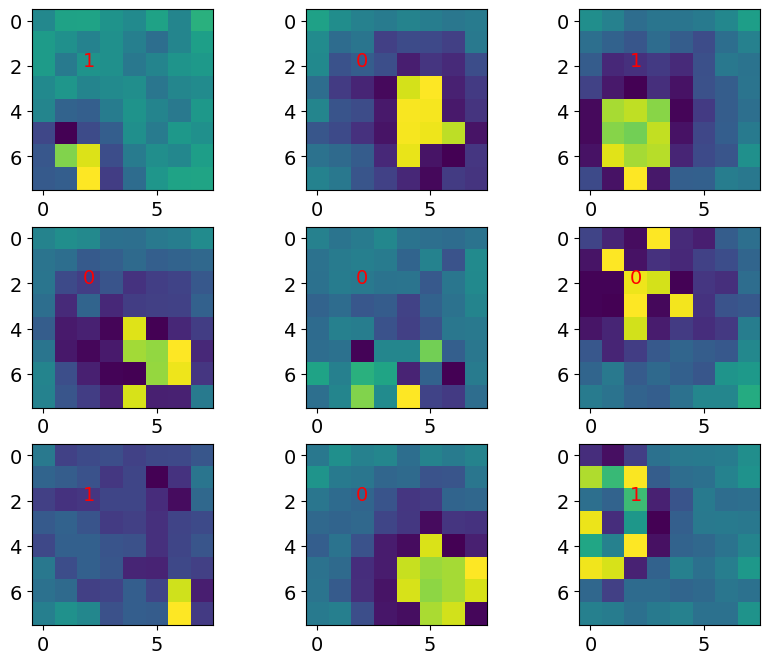

In [128]:
plot_images_and_labels(train_loader, start=500, figsize=(10, 8))

## Define model

In [137]:
CL = []
c1 = Conv2dPars(in_channels=1, out_channels=64, kernel_size=3, padding=1)
c2 = Conv2dPars(in_channels=64, out_channels=128, kernel_size=3, padding=1)
c3 = Conv2dPars(in_channels=128, out_channels=256, kernel_size=2, padding=1)
c4 = Conv2dPars(in_channels=256, out_channels=512, kernel_size=2, padding=1)
p2d = MaxPool2dPars(kernel_size=2, stride=2)
CL.append(build_conv_layer(c1, p2d, relu='standard'))
CL.append(build_conv_layer(c2, p2d, relu='standard'))
CL.append(build_conv_layer(c3, p2d, relu='standard'))
CL.append(build_conv_layer(c4, p2d, relu='standard'))
clyrs = build_conv_layers(CL)

In [130]:
cnn_evaluation(torch.randn(1,1,8,8), CL)

shape of input image = torch.Size([1, 1, 8, 8])
 after cl = 1, shape of out image = torch.Size([1, 64, 4, 4])
 after cl = 2, shape of out image = torch.Size([1, 128, 2, 2])
 after cl = 3, shape of out image = torch.Size([1, 256, 1, 1])
 after cl = 4, shape of out image = torch.Size([1, 512, 1, 1])
shape of flattened image = torch.Size([1, 512])


In [138]:
LLYR=[]
LLYR.append(LinealLayerPars(512, 256))
LLYR.append(LinealLayerPars(256, 128))
LLYR.append(LinealLayerPars(128, 2))
llyrs = build_linear_layers(LLYR, df=0.25)

In [139]:
model = CNN(clyrs,llyrs).to(device)

In [140]:
summary(model,(1,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
              ReLU-3             [-1, 64, 8, 8]               0
         MaxPool2d-4             [-1, 64, 4, 4]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
       BatchNorm2d-6            [-1, 128, 4, 4]             256
              ReLU-7            [-1, 128, 4, 4]               0
         MaxPool2d-8            [-1, 128, 2, 2]               0
            Conv2d-9            [-1, 256, 3, 3]         131,328
      BatchNorm2d-10            [-1, 256, 3, 3]             512
             ReLU-11            [-1, 256, 3, 3]               0
        MaxPool2d-12            [-1, 256, 1, 1]               0
           Conv2d-13            [-1, 512, 2, 2]         524,800
      BatchNorm2d-14            [-1, 51

In [141]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)  


In [142]:
x_single_run(train_loader, device, model, optimizer, criterion, xc=True)

** Run for 1 event**
epoch = 0
i = 0
labels shape = torch.Size([100])
imgs shape = torch.Size([100, 1, 8, 8])
labels = tensor([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 1])
outputs = torch.Size([100, 2])
predicted label = tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0], device='cuda:0')
correct = 44
Train Step 1/3590, Loss: 0.7018303871154785
i = 1
labels shape = torch.Size([100])
imgs shape = torch.Size([100, 1, 8, 8

In [143]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                            batch_size=64, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->229760 images
size of train loader  ->3590 images
Evaluating with  ->65664 images
size of eval loader  ->1026 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 0 AVG TRAIN LOSS: 0.6731891951687157
--- EPOCH 0 AVG VAL LOSS: 0.6764931409214905
Accuracy on the 1026 validation images: 55.79889619127484 %

EPOCH 1
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 1 AVG TRAIN LOSS: 0.6502049793772047
--- EPOCH 1 AVG VAL LOSS: 0.666771299076824
Accuracy on the 1026 validation images: 56.28644421475515 %

EPOCH 2
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 2 AVG TRAIN LOSS: 0.6421834947006948
--- EPOCH 2 AVG VAL LOSS: 0.7956902767017803
Accuracy on the 1026 validation images: 54.80917370360981 %

EPOCH 3
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 3 AVG TRAIN LOSS: 0.6367589434

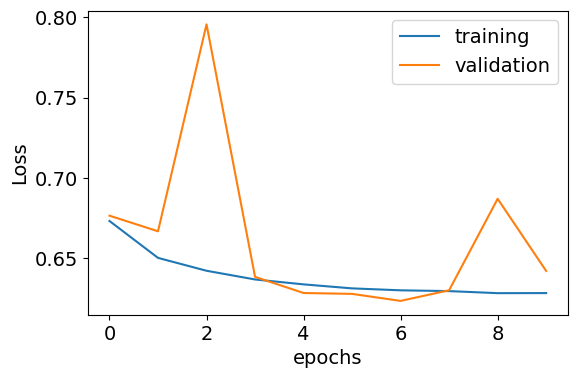

In [144]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

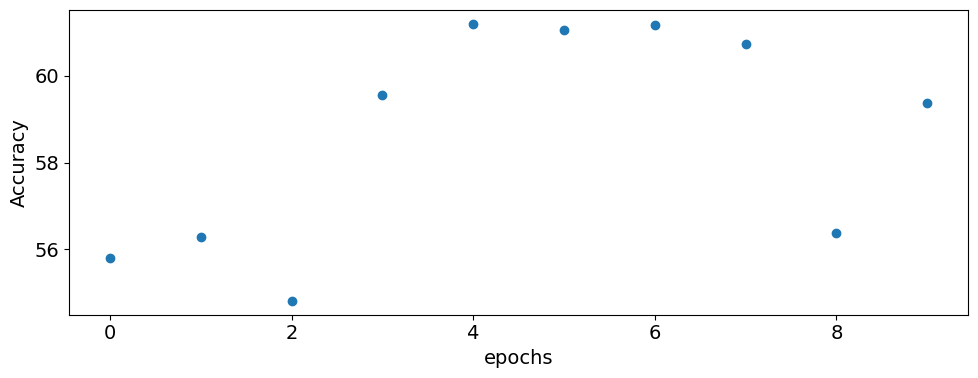

In [145]:
plot_accuracy(acc,figsize=(10, 4))

## Resnet

In [146]:
model = ResNet8(ResBlock, in_channels=1, out_channels=64, num_classes = 2, 
                 dropout_fraction=0.25, debug=True, dropout=True).to(device)

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [147]:
model(torch.randn(10,1,8,8).to(device))

  ResNet8: input data shape =>torch.Size([10, 1, 8, 8])
  ResNet8: after conv1 =>torch.Size([10, 64, 8, 8])
  ResNet8: after layer0 =>torch.Size([10, 64, 8, 8])
  ResNet8: after layer1 =>torch.Size([10, 128, 4, 4])
  ResNet8: after layer2 =>torch.Size([10, 256, 2, 2])
  ResNet8: after layer3 =>torch.Size([10, 512, 1, 1])
  ResNet8: after avgpool =>torch.Size([10, 512, 1, 1])
  ResNet8: after flatten =>torch.Size([10, 512])
  ResNet8: after fc =>torch.Size([10, 2])


tensor([[ 1.0435, -1.5842],
        [ 0.7612, -0.1676],
        [ 1.2299,  0.4068],
        [ 0.5560, -1.5140],
        [ 0.3335, -0.5792],
        [ 0.5408,  0.0453],
        [ 1.1362,  0.4734],
        [ 1.0504,  0.7362],
        [ 0.6457, -0.8150],
        [ 1.3093, -0.4191]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [148]:
summary(model,(1,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
              ReLU-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          36,928
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          36,928
       BatchNorm2d-8             [-1, 64, 8, 8]             128
              ReLU-9             [-1, 64, 8, 8]               0
         ResBlock-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 128, 4, 4]          73,856
      BatchNorm2d-12            [-1, 128, 4, 4]             256
             ReLU-13            [-1, 128, 4, 4]               0
           Conv2d-14            [-1, 12

In [149]:
optimizer= optim.Adam(model.parameters(), lr=0.001)

In [150]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                            batch_size=64, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->229760 images
size of train loader  ->3590 images
Evaluating with  ->65664 images
size of eval loader  ->1026 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 0 AVG TRAIN LOSS: 0.6636898443227359
--- EPOCH 0 AVG VAL LOSS: 0.6399174657946209
Accuracy on the 1026 validation images: 60.171226865846286 %

EPOCH 1
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 1 AVG TRAIN LOSS: 0.6258768464197355
--- EPOCH 1 AVG VAL LOSS: 0.6289099417118533
Accuracy on the 1026 validation images: 61.72065448446672 %

EPOCH 2
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 2 AVG TRAIN LOSS: 0.6155670380857994
--- EPOCH 2 AVG VAL LOSS: 0.6088567728768548
Accuracy on the 1026 validation images: 63.16769701815629 %

EPOCH 3
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 3 AVG TRAIN LOSS: 0.60796350

In [151]:
optimizer= optim.Adam(model.parameters(), lr=0.01)

In [152]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                            batch_size=64, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->229760 images
size of train loader  ->3590 images
Evaluating with  ->65664 images
size of eval loader  ->1026 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 0 AVG TRAIN LOSS: 0.6293685786073254
--- EPOCH 0 AVG VAL LOSS: 0.6811383232968128
Accuracy on the 1026 validation images: 58.92797940597149 %

EPOCH 1
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 1 AVG TRAIN LOSS: 0.614358052835491
--- EPOCH 1 AVG VAL LOSS: 0.6081063697735468
Accuracy on the 1026 validation images: 63.22132730073912 %

EPOCH 2
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 2 AVG TRAIN LOSS: 0.6062959108844109
--- EPOCH 2 AVG VAL LOSS: 0.6108398331187622
Accuracy on the 1026 validation images: 63.35979093940753 %

EPOCH 3
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 3 AVG TRAIN LOSS: 0.6001518348

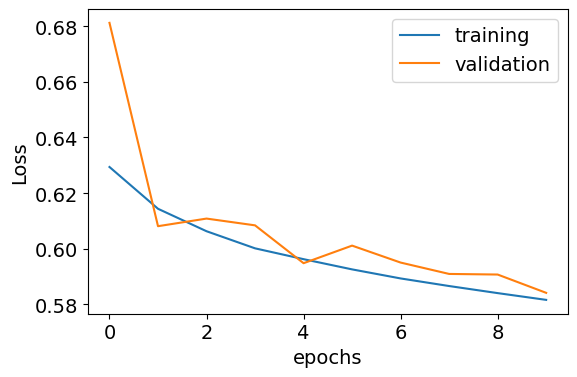

In [153]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

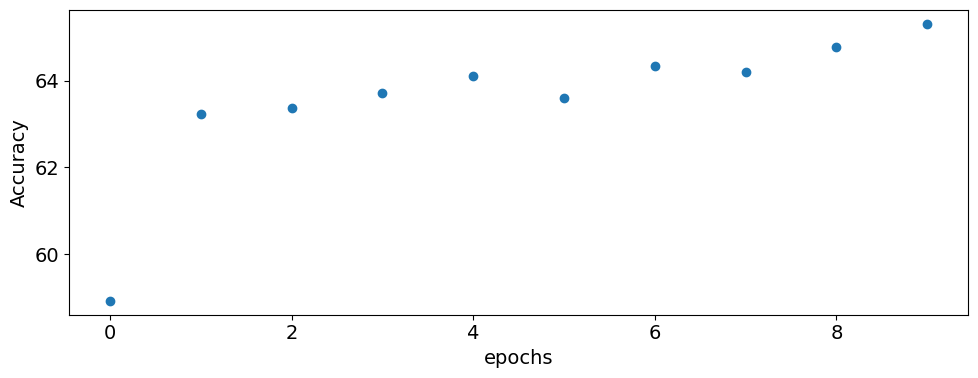

In [154]:
plot_accuracy(acc,figsize=(10, 4))